# Statistics about the Collected Package APIs

In [2]:
import pandas as pd
import multiprocessing as mp
import matplotlib.pyplot as plt
import py4a.api.accessor as accessor
from tqdm import tqdm
from copy import deepcopy
from datetime import timedelta
from collections import defaultdict, Counter
from dateutil.parser import parse as parse_date
from packaging.requirements import Requirement
from py4a.util import get_spec_type

In [3]:
stats = pd.DataFrame(sum(accessor.get_stats_all().values(), []))
print(
    f"{stats.package.nunique()} packages, {len(stats)} versions, "
    f"{stats.wheel.count()} versions ({stats[stats.wheel.notna()].package.nunique()} packages) with wheel"
)
stats.head(1)

9637 packages, 580005 versions, 415127 versions (7668 packages) with wheel


,package,version,time,requires_python,requires_dist,wheel,wheel_top_levels,summary_static,summary_dynamic
0,itsdangerous,0.10,2011-06-29T13:26:18,None,None,None,None,None,None


## Statistics About Wheels

      Has Wheel  No Wheel
2005          0        38
2006          0       191
2007          0       362
2008          0       731
2009          1      1484
2010          1      2222
2011          5      3273
2012         13      5237
2013        235      9028
2014       2192     11378
2015       5577     12038
2016      10176     12690
2017      15086     15148
2018      23403     14638
2019      44156     18893
2020     114987     41721
2021     198903     12745
2022        385        37


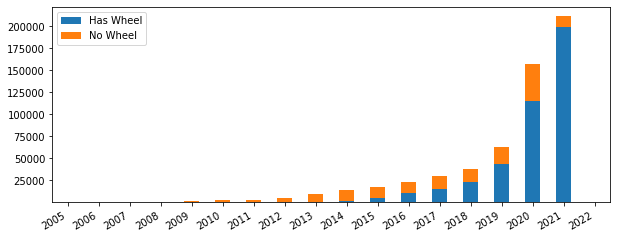

In [5]:
year2wheels = defaultdict(lambda: {"Has Wheel": 0, "No Wheel": 0})
for t, wheel in zip(stats.time, stats.wheel):
    if pd.isnull(t):
        continue
    t = parse_date(t)
    if wheel is not None:
        year2wheels[t.year]["Has Wheel"] += 1
    else:
        year2wheels[t.year]["No Wheel"] += 1
year2wheels = pd.DataFrame.from_dict(year2wheels, orient="index").sort_index()
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
year2wheels.plot(kind="bar", stacked="True", mark_right=True, use_index=True, ax=ax)
fig.autofmt_xdate()
fig.savefig("evaluation/figs/pkg_whl_dist_by_year.pdf", bbox_inches="tight")
print(year2wheels)

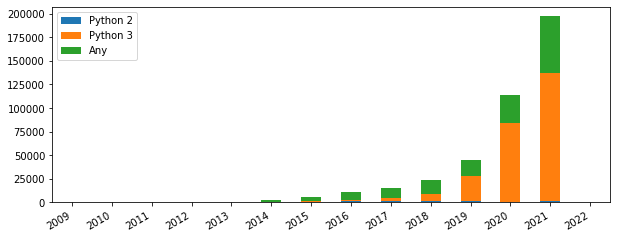

In [5]:
wheel2pyver = defaultdict(lambda: {"Python 2": 0, "Python 3": 0, "Any": 0})
for t, wheel in zip(stats.time, stats.wheel):
    if wheel is None or pd.isnull(t):
        continue
    t = parse_date(t)
    for item in wheel.split("-"):
        if item.startswith("py"):
            if "py3" in item and "py2" in item:
                wheel2pyver[t.year]["Any"] += 1
            elif "py3" in item:
                wheel2pyver[t.year]["Python 3"] += 1
            elif "py2" in item:
                wheel2pyver[t.year]["Python 2"] += 1
            else:
                wheel2pyver[t.year]["Any"] += 1
wheel2pyver = pd.DataFrame.from_dict(wheel2pyver, orient="index").sort_index()
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
wheel2pyver.plot(kind="bar", stacked="True", mark_right=True, use_index=True, ax=ax)
fig.autofmt_xdate()
fig.savefig("evaluation/figs/pkg_whl_pyver_by_year.pdf", bbox_inches="tight")

## Statistics about Dependency Specifications

In [5]:
def get_deps(pkg, ver, t, req):
    x = Requirement(req)
    if x.marker is not None or len(x.extras) > 0:
        return None
    return {
        "pkg": pkg,
        "ver": ver,
        "time": t,
        "type": get_spec_type(req),
        "dep": req,
    }
params = []
for pkg, ver, t, req in zip(stats.package, stats.version, stats.time, stats.requires_dist):
    if req is None:
        continue
    params.extend((pkg, ver, t, r) for r in req)
with mp.Pool(mp.cpu_count()) as pool:
    deps = pd.DataFrame(filter(lambda x: x is not None, pool.starmap(get_deps, params)))
print(
    f"{len(deps)} deps from {deps.pkg.nunique()} packages "
    f"and {len(set(zip(deps.pkg, deps.ver)))} versions"
)
for k, v in sorted(Counter(deps.type).items(), key=lambda x: -x[1]):
    print(f"{k:10s}: {v:7d} ({100*v/len(deps):4.2f}%)")

1631465 deps from 5857 packages and 213180 versions
any       :  487666 (29.89%)
fixed     :  410599 (25.17%)
at-least  :  376528 (23.08%)
range     :  236232 (14.48%)
at-most   :   49166 (3.01%)
var-micro :   34033 (2.09%)
other     :   22285 (1.37%)
var-minor :   14956 (0.92%)


In [6]:
deps = deps[deps.time.notnull()]
year2dep_type = dict()
for time, dep_type in tqdm(zip(deps.time, deps.type), total=len(deps)):
    y = parse_date(time).year
    if y not in year2dep_type:
        year2dep_type[y] = {"any": 0, "at-least": 0, "range": 0, "fixed": 0, "other": 0}
    if dep_type in year2dep_type[y]:
        year2dep_type[y][dep_type] += 1
    elif dep_type == "var-minor" or dep_type == "var-micro":
        year2dep_type[y]["range"] += 1
    else:
        year2dep_type[y]["other"] += 1
to_del = set()
for year, counter in sorted(year2dep_type.items(), key=lambda x: x[0]):
    s = sum(counter.values())
    print(year, s)
    if s < 1000:
        to_del.add(year)
    for v in counter:
        counter[v] = counter[v] / s
for y in to_del:
    del year2dep_type[y]
year2dep_type = pd.DataFrame.from_dict(year2dep_type, orient="index").sort_index().fillna(0)

100%|██████████| 1631221/1631221 [01:18<00:00, 20696.83it/s]


2013 4
2014 394
2015 10932
2016 23479
2017 55463
2018 108883
2019 255381
2020 486461
2021 690224


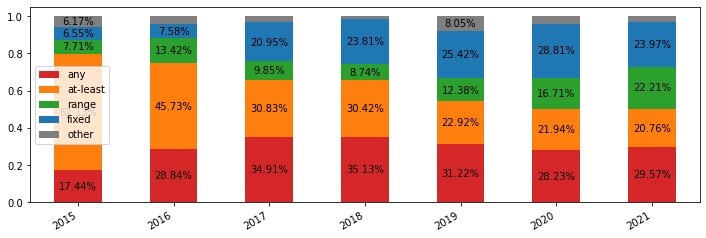

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
year2dep_type.plot(kind="bar", stacked="True", mark_right=True, use_index=True, ax=ax, 
    color=["tab:red", "tab:orange", "tab:green", "tab:blue", "tab:gray"])
for i, (y, types) in enumerate(year2dep_type.iterrows()):
    x = 0
    for t, c in types.items():
        x = x + c * 0.5
        if c > 0.05:
            ax.text(i, x, f"{100*c:.2f}%", ha="center", va="center")
        x = x + c * 0.5
fig.autofmt_xdate()
fig.savefig("evaluation/figs/pkg_dep_type_by_year.png", bbox_inches="tight")

## Statistics About APIs (Both from Static Analysis and Dynamic Analysis)

In [6]:
stats_s = []
for stat in filter(lambda x: x is not None, stats.summary_static):
    stat = deepcopy(stat)
    if stat["api_statistics"] is not None:
        for k in ["top_levels", "num_apis", "num_functions", 
                  "num_classes", "num_variables", "num_aliases", "num_modules"]:
            if k in stat["api_statistics"]:
                stat[k] = stat["api_statistics"][k]
    del stat["api_statistics"]
    stats_s.append(stat)
stats_s = pd.DataFrame(stats_s)
stats_no_err_s = stats_s[~stats_s["error"]].copy()
stats_no_fmod_s = stats_s[~stats_s["error"] & stats_s.failed_modules.map(lambda x: x is not None and len(x) == 0)]
num_mods = sum(stats_no_err_s[stats_no_err_s.num_modules.notna()].num_modules)
num_fmods = sum(stats_no_err_s.failed_modules.map(len))
print(
    "Static API Analysis:\n"
    f"  {len(stats_no_err_s)} versions ({stats_no_err_s.package.nunique()} packages) have no error\n"
    f"  {len(stats_no_fmod_s)} versions ({stats_no_fmod_s.package.nunique()} packages) have no failed modules\n"
    f"  {num_mods} successful modules and {num_fmods} failed modules\n"
    f"  {sum(stats_no_err_s.num_apis)} apis, "
    f"{sum(stats_no_err_s.num_functions)} functions, "
    f"{sum(stats_no_err_s.num_classes)} classes, "
    f"{sum(stats_no_err_s.num_variables)} variables, "
    f"{sum(stats_no_err_s.num_aliases)} aliases"
)

Static API Analysis:
  415105 versions (7668 packages) have no error
  397962 versions (7581 packages) have no failed modules
  26322830.0 successful modules and 164791 failed modules
  357385275.0 apis, 33832920.0 functions, 86244572.0 classes, 60682629.0 variables, 170280964.0 aliases


In [9]:
stats_d = []
for stat in filter(lambda x: x is not None, stats.summary_dynamic):
    stat = deepcopy(stat)
    if stat["api_statistics"] is not None:
        for k in ["top_levels", "num_apis", "num_functions", 
                  "num_classes", "num_variables", "num_aliases", "num_modules"]:
            if k in stat["api_statistics"]:
                stat[k] = stat["api_statistics"][k]
    del stat["api_statistics"]
    stats_d.append(stat)
stats_d = pd.DataFrame(stats_d)
stats_no_err_d = stats_d[~stats_d["error"]].copy()
stats_no_fmod_d = stats_d[~stats_d["error"] & stats_d.failed_modules.map(lambda x: x is not None and len(x) == 0)]
num_mods = sum(stats_no_err_d[stats_no_err_d.num_modules.notna()].num_modules)
num_fmods = sum(stats_no_err_d.failed_modules.map(len))
print(
    "Dynamic API Analysis:\n"
    f"  {len(stats_no_err_d)} versions ({stats_no_err_d.package.nunique()} packages) have no error\n"
    f"  {len(stats_no_fmod_d)} versions ({stats_no_fmod_d.package.nunique()} packages) have no failed modules\n"
    f"  {num_mods} successful modules and {num_fmods} failed modules\n"
    f"  {sum(stats_no_err_d.num_apis)} apis, "
    f"{sum(stats_no_err_d.num_functions)} functions, "
    f"{sum(stats_no_err_d.num_classes)} classes, "
    f"{sum(stats_no_err_d.num_variables)} variables, "
    f"{sum(stats_no_err_d.num_aliases)} aliases"
)

Dynamic API Analysis:
  380345 versions (7289 packages) have no error
  226608 versions (6412 packages) have no failed modules
  4074562.0 successful modules and 175356 failed modules
  46906625.0 apis, 12374718.0 functions, 18147990.0 classes, 8531484.0 variables, 7841508.0 aliases


In [10]:
! du data/apis -h | tail -n 1
! du data/apid -h | tail -n 1

30G	data/apis
8.9G	data/apid


In [11]:
stats_no_err_s.time_begin = stats_no_err_s.time_begin.map(parse_date)
stats_no_err_s.time_end = stats_no_err_s.time_end.map(parse_date)
stats_no_err_d.time_begin = stats_no_err_d.time_begin.map(parse_date)
stats_no_err_d.time_end = stats_no_err_d.time_end.map(parse_date)
time_static = stats_no_err_s.time_end - stats_no_err_s.time_begin
time_dynamic = stats_no_err_d.time_end - stats_no_err_d.time_begin
print(sum(time_static, timedelta()), sum(time_dynamic, timedelta()))
pd.DataFrame({"static": time_static, "dynamic": time_dynamic}).describe()

3 days 16:28:40.592598 103 days 21:38:52.618578


,static,dynamic
count,413492,380345
mean,0 days 00:00:00.770318633,0 days 00:00:23.602604526
std,0 days 00:00:03.089566732,0 days 00:06:24.111670056
min,0 days 00:00:00.001848,0 days 00:00:06.928392
25%,0 days 00:00:00.051564,0 days 00:00:09.652326
50%,0 days 00:00:00.121210,0 days 00:00:12.395129
75%,0 days 00:00:00.381903,0 days 00:00:18.246913
max,0 days 00:03:07.609529,1 days 14:42:22.436672


In [12]:
stats_err_s = pd.DataFrame(
    list(
        stats[
            stats.summary_static.map(lambda s: s is not None and s["error"])
        ].summary_static
    )
)
def get_static_error_type(s):
    if "FileNotFoundError" in s:
        return "FileNotFoundError: '/' in top level"
    elif "FileExistsError" in s:
        return "FileExistsError: some intermittent zip extraction was terminated"
    else:
        return "Other"
stats_err_s["type"] = stats_err_s.stack_trace.map(get_static_error_type)
Counter(stats_err_s.type)

Counter({"FileNotFoundError: '/' in top level": 1353,
         'FileExistsError: some intermittent zip extraction was terminated': 42,
         'Other': 22})

In [13]:
stats_err_d = pd.DataFrame(
    list(
        stats[
            stats.summary_dynamic.map(lambda s: s is not None and s["error"])
        ].summary_dynamic
    )
)
def get_dynamic_error_type(s):
    if "PackageInstallException" in s:
        return "PackageInstallException: Cannot install package in a conda env with Python>=3.6"
    elif "JSONDecodeError" in s:
        return "JSONDecodeError: Other kind of runtime exception occurred"
    elif "FileNotFoundError" in s:
        return "FileNotFoundError: '/' in top level"
    else:
        return "Other"
stats_err_d["type"] = stats_err_d.stack_trace.map(get_dynamic_error_type)
Counter(stats_err_d.type)

Counter({'PackageInstallException: Cannot install package in a conda env with Python>=3.6': 31174,
         "FileNotFoundError: '/' in top level": 1175,
         'JSONDecodeError: Other kind of runtime exception occurred': 1979,
         'Other': 88})

In [14]:
df = pd.DataFrame(
    list(
        stats[
            stats.summary_static.map(
                lambda s: s is not None
                and not s["error"]
                and len(s["failed_modules"]) > 0
            )
        ].summary_static
    )
)
stats_fmod_s = []
for pkg, ver, fmods in zip(df.package, df.version, df.failed_modules):
    for mod, err in fmods.items():
        stats_fmod_s.append(
            {"package": pkg, "version": ver, "module": mod, "error": err}
        )
stats_fmod_s = pd.DataFrame(stats_fmod_s)
def get_fmod_type(s):
    if (
        "SyntaxError" in s
        or "IndentationError" in s
        or "TabError" in s
        or "RecursionError" in s
    ):
        return "SyntaxError"
    return "Other"
stats_fmod_s["type"] = stats_fmod_s.error.map(get_fmod_type)
Counter(stats_fmod_s.type)

Counter({'SyntaxError': 152331})

In [15]:
df = pd.DataFrame(
    list(
        stats[
            stats.summary_dynamic.map(
                lambda s: s is not None
                and not s["error"]
                and len(s["failed_modules"]) > 0
            )
        ].summary_dynamic
    )
)
stats_fmod_d = []
for pkg, ver, fmods in zip(df.package, df.version, df.failed_modules):
    for mod, err in fmods.items():
        stats_fmod_d.append(
            {"package": pkg, "version": ver, "module": mod, "error": err}
        )
stats_fmod_d = pd.DataFrame(stats_fmod_d)
def get_fmod_type(s):
    if "RecursionError" in s:
        return "RecursionError: inpsect module failed when inpecting API signature"
    elif "ImportError" in s or "ModuleNotFoundError" in s:
        return "ImportError: missing dependencies when importing this module"
    elif "SyntaxError" in s:
        return "SyntaxError: the module does not comply with Python 3.9 syntax or has syntax errors"
    return "Other: the module can fail due to all kinds of runtime errors (improper config, env, etc)"
stats_fmod_d["type"] = stats_fmod_d.error.map(get_fmod_type)
Counter(stats_fmod_d.type)

Counter({'SyntaxError: the module does not comply with Python 3.9 syntax or has syntax errors': 12036,
         'RecursionError: inpsect module failed when inpecting API signature': 4817,
         'ImportError: missing dependencies when importing this module': 133911,
         'Other: the module can fail due to all kinds of runtime errors (improper config, env, etc)': 24592})